In [1]:
from torchvision import models
from torch import nn
import torch

class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()
      
  def forward(self, x):
    return x

def get_vgg_model(num_outputs, init_scale):
  """
  Function to create vgg model used in paper.

  num_outputs: # of neurons in classifier layer that is equal to # of classes in the problem
  init_scale: Parameter used while initializing model weights
  """
  vgg16 = models.vgg16()

  # Remove avgpool since it's removed in the paper
  vgg16.avgpool = Identity()

  # In the paper, VGG16 model's 2 last FC layers are removed
  # 512 is for 32x32 image
  vgg16.classifier = nn.Linear(512, num_outputs)

  def init_weights(param):
    if (type(param) == nn.Conv2d or type(param) == nn.Linear):
      # Parameters are initialized with He initialization in the paper.
      torch.nn.init.kaiming_normal_(param.weight, mode='fan_out', nonlinearity='relu')

  vgg16.apply(init_weights)
  return vgg16

In [2]:
# install and import the torchinfo library
!pip install torchinfo
from torchinfo import summary

# get some info for the models to check if everything is OK
vgg16 = get_vgg_model(13, 1)
print(summary(vgg16, input_size=(1, 3, 32, 32)))
print(vgg16)

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 64, 32, 32]           36,928
│    └─ReLU: 2-4                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 128, 16, 16]          73,856
│    └─ReLU: 2-7                         [1, 128, 16, 16]          --
│    └

In [18]:
import torchvision.transforms as transforms
import torchvision
import copy
import numpy as np

def get_cifar10_sets(num_examples_upstream, num_examples_downstream, num_classes_upstream, \
                     num_classes_downstream, is_downstream_random, batch_size):
  """
  Function to create dataloaders to be used throughout the experiments.

  num_examples_upstream: # of samples to be used in upstream training
  num_examples_downstream: # of samples to be used in downstream training
  num_classes_upstream: # of random classes to be used in upstream training
  num_classes_downstream: # of random classes to be used in downstream training. If `is_downstream_random`
                          is False then this parameter will be ignored.
  is_downstream_random: Whether downstream task uses random labels. 
  batch_size: Batch size.
  """

  # as a result it normalizes the input between [-1,1]
  TF = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=TF)
  testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=TF)

  # Create random indices for splitting upstream and downstream tasks
  indices = np.arange(0,len(trainset))
  np.random.seed(12345)
  np.random.shuffle(indices)
  indices = indices.tolist()

  # Make upstream labels random
  temp = np.array(trainset.targets)
  temp[indices[:num_examples_upstream]] = np.random.randint(num_classes_upstream, size=num_examples_upstream)
  
  # If the downstream task uses random labels
  if is_downstream_random:
    np.random.seed(12345)
    temp[indices[-num_examples_downstream:]] = np.random.randint(num_classes_downstream, size=num_examples_downstream).tolist()
  trainset.targets = [int(label) for label in temp]

  # Build dataloaders for upstream and downstream tasks
  train_upstream_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False,
                                                sampler=torch.utils.data.SubsetRandomSampler(indices[:num_examples_upstream]))

  train_downstream_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False,
                                                sampler=torch.utils.data.SubsetRandomSampler(indices[-num_examples_downstream:]))

  test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

  # To check the random labels
  '''
  u_batch = next(iter(train_upstream_loader))
  d_batch = next(iter(train_downstream_loader))

  u_labels = u_batch[1]
  print(u_labels)
  d_labels = d_batch[1]
  print(d_labels)
  '''
  return (train_upstream_loader, train_downstream_loader, test_loader)


In [15]:
def accuracy(model, dataloader):
  """
  Calculates accuracy of model in given dataloader

  model: Model that the accuracy is calculated for
  dataloader: Dataloader to get samples that accuracy is calculated on
  """
  correct = 0
  total = 0

  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  return (correct / total)

def train(model, criterion, optimizer, epochs, dataloader, device, scheduler=None,
          acc_mode="none", acc_dataloaders=None, verbose=True):
  """
  Trains given model with given configuration.

  model: Model to be used
  criterion: Loss function to be used
  optimizer: Optimizer to be used.
  epochs: # of epochs
  dataloader: Dataloader for training set
  device: which hardware the model is trained on. CPU or GPU(cuda)
  scheduler: learning rate scheduler
  acc_mode: Accuracy mode indicating that which datasets accuracy metrics are calculated.
            "none"   = no accuracy calculation
            "traing" = accuracy calculation on training set
            "both"   = accuracy calculation on both training and test set
  acc_dataloaders: Dataloaders to get samples that are used for accuracy calculation. Value of this
                   parameter should match with `acc_mode`. For example given `acc_mode` with "both"
                   option, two dataloaders should be given inside this parameter.
  verbose: Verbosity option
  """
  loss_history = []
  train_accuracies = []
  test_accuracies = []
  for epoch in range(1,epochs+1):
    count = 0
    for i, data in enumerate(dataloader, 0):     
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # canonical forward-backward-update chain
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs.to(device), labels)
      loss.backward()
      optimizer.step()
      
      loss_history.append(loss.item())
      # count is used to control resolution of accuracy data. Experiments in the paper calculates
      # accuracy on the whole training-test set each iteration which is very time consuming. With
      # the variable it's just made less frequent.

      count += 1
      if (count % 15 == 0):
          if acc_mode=="both":
            train_acc = accuracy(model, acc_dataloaders[0])
            train_accuracies.append(train_acc)
            test_acc = accuracy(model, acc_dataloaders[1])
            test_accuracies.append(test_acc)
          elif acc_mode=="train":
            train_acc = accuracy(model, acc_dataloaders[0])
            train_accuracies.append(train_acc)
          elif acc_mode=="test":
            test_acc = accuracy(model, acc_dataloaders[1])
            test_accuracies.append(test_acc)
    
    if verbose: 
        print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')
        if acc_mode=="train" or acc_mode =="both":
          print(f'Epoch {epoch} / {epochs}: Last train acc:{train_acc}')
        if acc_mode=="test" or acc_mode =="both":
          print(f'Epoch {epoch} / {epochs}: Last test acc:{test_acc}')

    if scheduler is not None:
      scheduler.step()
      # Print Learning Rate
      print('Epoch:', epoch,'LR:', scheduler.get_last_lr())

  if acc_mode=="both":
    return loss_history, train_accuracies, test_accuracies
  elif acc_mode=="train":
    return loss_history, train_accuracies
  elif acc_mode=="test":
    return loss_history, test_accuracies
  return loss_history


In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def get_training_components(learnable_params, init_lr, step_size):
  '''
  Function to prepare components of the training. These are all the same
  throughout the experiments made.
  
  learnable_params: Parameters that optimizer runs to update.
  init_lr: Initial learning rate that scheduler is given. 
  step_size: step size of lowering learning rate. Every `step_size` epochs
             learning rate will be scaled by constant 1/3.
  '''
  # The problem always be a image classification
  criterion = nn.CrossEntropyLoss()
  # Which parameters to be updated depends on if the training is done from scratch
  # or with pre-trained model.
  optimizer = optim.SGD(learnable_params, lr=init_lr, momentum=0.9)
  # Step size depends on the # of epoch, gamma is contant in the paper
  scheduler = StepLR(optimizer, step_size=step_size, gamma=1/3)
  return (criterion, optimizer, scheduler)

def get_device():
  if torch.cuda.is_available():
    print("Cuda (GPU support) is available and enabled!")
    device = torch.device("cuda")
  else:
    print("Cuda (GPU support) is not available :(")
    device = torch.device("cpu")

def get_learnable_parameters(model):
  params_to_update = []
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
  return params_to_update


In [6]:
# Upstream training for 1st and 2nd graphs of figure1
from torch import linalg as LA

train_upstream_loader, train_downstream_loader, test_loader = get_cifar10_sets(
    num_examples_upstream = 20000,
    num_examples_downstream = 20000,
    num_classes_upstream = 5,
    num_classes_downstream = 5,
    is_downstream_random = False,
    batch_size = 256
  )

model = get_vgg_model(5, 1)
norm_dict = {}
for name, param in model.named_parameters():
  norm_dict[name] = LA.norm(param)

epochs = 120
learnable_parameters = get_learnable_parameters(model)
criterion, optimizer, scheduler = get_training_components(learnable_parameters, 0.001, (int)(epochs/3))

device = get_device()
model = model.to(device)
model.train()
loss_history = train(model, criterion, optimizer, epochs, train_upstream_loader, device, scheduler=scheduler)

# scale norms back to initial values after upstream training
for name, param in model.named_parameters():
  scale = norm_dict[name]
  param.data.copy_(param*(scale.item()/LA.norm(param)))

# save upstream training
torch.save(model.state_dict(), "./pretrained_model_dict_upstream_1_2.pt")
torch.save(model, "./pretrained_model_upstream_1_2.pt")


Cuda (GPU support) is available and enabled!
Epoch 1 / 120: avg. loss of last 5 iterations 1.6133390665054321
Epoch: 1 LR: [0.001]
Epoch 2 / 120: avg. loss of last 5 iterations 1.6077460765838623
Epoch: 2 LR: [0.001]
Epoch 3 / 120: avg. loss of last 5 iterations 1.605721402168274
Epoch: 3 LR: [0.001]
Epoch 4 / 120: avg. loss of last 5 iterations 1.6093560218811036
Epoch: 4 LR: [0.001]
Epoch 5 / 120: avg. loss of last 5 iterations 1.6039263248443603
Epoch: 5 LR: [0.001]
Epoch 6 / 120: avg. loss of last 5 iterations 1.5962279558181762
Epoch: 6 LR: [0.001]
Epoch 7 / 120: avg. loss of last 5 iterations 1.606328511238098
Epoch: 7 LR: [0.001]
Epoch 8 / 120: avg. loss of last 5 iterations 1.5934141874313354
Epoch: 8 LR: [0.001]
Epoch 9 / 120: avg. loss of last 5 iterations 1.5921808719635009
Epoch: 9 LR: [0.001]
Epoch 10 / 120: avg. loss of last 5 iterations 1.5870641946792603
Epoch: 10 LR: [0.001]
Epoch 11 / 120: avg. loss of last 5 iterations 1.585596537590027
Epoch: 11 LR: [0.001]
Epoch 12

In [16]:
def setup_and_train_downstream(epochs, lr, step_size, num_examples_upstream, num_examples_downstream,
                   num_classes_upstream, num_classes_downstream, is_downstream_random,
                   batch_size, num_outputs, upstream_model_path=None):
  """
  Creates required parameters for downstream task and starts training. 

  epochs: # of epochs
  lr: learning rate
  num_examples_upstream: # of samples to be used in upstream training
  num_examples_downstream: # of samples to be used in downstream training
  num_classes_upstream: # of random classes to be used in upstream training
  num_classes_downstream: # of random classes to be used in downstream training. If `is_downstream_random`
                          is False then this parameter will be ignored.
  is_downstream_random: Whether downstream task uses random labels. 
  batch_size: Batch size.
  num_outputs: # of neurons in classifier layer that is equal to # of classes in the problem
  upstream_model_path: Path to load weights of upstream training.
  """
    train_upstream_loader, train_downstream_loader, test_loader = get_cifar10_sets(
        num_examples_upstream, num_examples_downstream, num_classes_upstream,
        num_classes_downstream, is_downstream_random, batch_size)
    
    # separate dataloader only used for accuracy
    _, acc_train_loader, acc_test_loader = get_cifar10_sets(
        num_examples_upstream = 5000,
        num_examples_downstream = num_examples_downstream,
        num_classes_upstream = 5,
        num_classes_downstream = num_classes_downstream,  
        is_downstream_random = is_downstream_random,
        batch_size = num_examples_downstream
    )

    # to not get an error while loading state of upstream training, classification layer is
    # initialized with `num_classes_downstream` neurons. Afterwards, layer is corrected with
    # `num_outputs` parameter
    model = get_vgg_model(num_classes_downstream, 1)
    if upstream_model_path is not None:
        model.load_state_dict(torch.load(upstream_model_path), strict=False)
        model.classifier = nn.Linear(512, num_outputs)
        torch.nn.init.kaiming_normal_(model.classifier.weight, mode='fan_out', nonlinearity='relu')

    learnable_parameters = get_learnable_parameters(model)
    criterion, optimizer, scheduler = get_training_components(learnable_parameters, lr, step_size)
    device = get_device()
    model = model.to(device)
    model.train()
    if not is_downstream_random:
      loss_history, train_accuracies, test_accuracies = train(model, criterion, optimizer, epochs, train_downstream_loader, 
                                                              device, scheduler, "both",
                                                              [acc_train_loader, acc_test_loader])
      return loss_history, train_accuracies, test_accuracies
    loss_history, train_accuracies = train(model, criterion, optimizer, epochs, train_downstream_loader, 
                                           device, scheduler, "train",
                                           [acc_train_loader])
    return loss_history, train_accuracies

In [36]:
# From scratch with real labels
loss_scratch_real, accs_scratch_real_train, accs_scratch_real_test = setup_and_train_downstream(
    epochs=40, lr=0.001, step_size=(int)(40/3), num_examples_upstream=20000, 
    num_examples_downstream=20000, num_classes_upstream = 5, num_classes_downstream = 10,
    is_downstream_random = False, batch_size = 256, num_outputs=10
)


Cuda (GPU support) is available and enabled!
Epoch 1 / 40: avg. loss of last 5 iterations 1.9438912868499756
Epoch 1 / 40: Last train acc:0.2959
Epoch 1 / 40: Last test acc:0.2926
Epoch: 1 LR: [0.001]
Epoch 2 / 40: avg. loss of last 5 iterations 1.572124433517456
Epoch 2 / 40: Last train acc:0.408
Epoch 2 / 40: Last test acc:0.4012
Epoch: 2 LR: [0.001]
Epoch 3 / 40: avg. loss of last 5 iterations 1.4606171131134034
Epoch 3 / 40: Last train acc:0.46285
Epoch 3 / 40: Last test acc:0.4473
Epoch: 3 LR: [0.001]
Epoch 4 / 40: avg. loss of last 5 iterations 1.4026540517807007
Epoch 4 / 40: Last train acc:0.48055
Epoch 4 / 40: Last test acc:0.4619
Epoch: 4 LR: [0.001]
Epoch 5 / 40: avg. loss of last 5 iterations 1.313452458381653
Epoch 5 / 40: Last train acc:0.4956
Epoch 5 / 40: Last test acc:0.4756
Epoch: 5 LR: [0.001]
Epoch 6 / 40: avg. loss of last 5 iterations 1.3186028957366944
Epoch 6 / 40: Last train acc:0.55645
Epoch 6 / 40: Last test acc:0.5267
Epoch: 6 LR: [0.001]
Epoch 7 / 40: avg. 

In [38]:
# Using upstream training's weights with real labels
loss_upstream_real, accs_upstream_real_train, accs_upstream_real_test = setup_and_train_downstream(
    epochs=40, lr=0.001, step_size=(int)(40/3), num_examples_upstream=20000, 
    num_examples_downstream=20000, num_classes_upstream = 5, num_classes_downstream = 5,
    is_downstream_random = False, batch_size = 256, num_outputs=10,
    upstream_model_path = "pretrained_model_dict_upstream_1_2.pt"
)


Cuda (GPU support) is available and enabled!
Epoch 1 / 40: avg. loss of last 5 iterations 1.8009793758392334
Epoch 1 / 40: Last train acc:0.35105
Epoch 1 / 40: Last test acc:0.3484
Epoch: 1 LR: [0.001]
Epoch 2 / 40: avg. loss of last 5 iterations 1.5928424835205077
Epoch 2 / 40: Last train acc:0.4659
Epoch 2 / 40: Last test acc:0.4452
Epoch: 2 LR: [0.001]
Epoch 3 / 40: avg. loss of last 5 iterations 1.4084606647491456
Epoch 3 / 40: Last train acc:0.4881
Epoch 3 / 40: Last test acc:0.4584
Epoch: 3 LR: [0.001]
Epoch 4 / 40: avg. loss of last 5 iterations 1.4288152217864991
Epoch 4 / 40: Last train acc:0.5488
Epoch 4 / 40: Last test acc:0.496
Epoch: 4 LR: [0.001]
Epoch 5 / 40: avg. loss of last 5 iterations 1.3201460361480712
Epoch 5 / 40: Last train acc:0.57275
Epoch 5 / 40: Last test acc:0.5046
Epoch: 5 LR: [0.001]
Epoch 6 / 40: avg. loss of last 5 iterations 1.223764419555664
Epoch 6 / 40: Last train acc:0.6124
Epoch 6 / 40: Last test acc:0.5256
Epoch: 6 LR: [0.001]
Epoch 7 / 40: avg. 

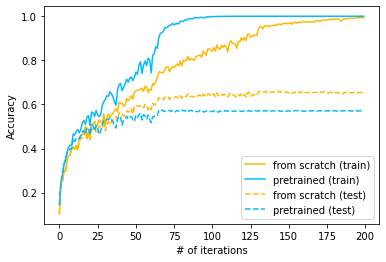

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

orange = "#fcba03"
light_blue = "#03bafc"

plt.plot(accs_scratch_real_train, linestyle="-", color=orange)
plt.plot(accs_upstream_real_train, linestyle="-", color=light_blue)
plt.plot(accs_scratch_real_test, linestyle="--", color=orange)
plt.plot(accs_upstream_real_test, linestyle="--", color=light_blue)
plt.legend(["from scratch (train)", "pretrained (train)", "from scratch (test)", "pretrained (test)"], loc ="best")
plt.xlabel('# of iterations')
plt.ylabel('Accuracy')
plt.show()

In [20]:
# From scratch with random labels
loss_upstream_real, accs_scratch_random_train = setup_and_train_downstream(
    epochs=75, lr=0.001, step_size=(int)(75/3), num_examples_upstream=20000, 
    num_examples_downstream=20000, num_classes_upstream = 5, num_classes_downstream = 5,
    is_downstream_random = True, batch_size = 256, num_outputs=5
)

Cuda (GPU support) is available and enabled!
Epoch 1 / 75: avg. loss of last 5 iterations 1.6176288604736329
Epoch 1 / 75: Last train acc:0.2188
Epoch: 1 LR: [0.001]
Epoch 2 / 75: avg. loss of last 5 iterations 1.615944743156433
Epoch 2 / 75: Last train acc:0.23425
Epoch: 2 LR: [0.001]
Epoch 3 / 75: avg. loss of last 5 iterations 1.6133175373077393
Epoch 3 / 75: Last train acc:0.23545
Epoch: 3 LR: [0.001]
Epoch 4 / 75: avg. loss of last 5 iterations 1.6103538990020752
Epoch 4 / 75: Last train acc:0.2226
Epoch: 4 LR: [0.001]
Epoch 5 / 75: avg. loss of last 5 iterations 1.610700750350952
Epoch 5 / 75: Last train acc:0.23595
Epoch: 5 LR: [0.001]
Epoch 6 / 75: avg. loss of last 5 iterations 1.5970714807510376
Epoch 6 / 75: Last train acc:0.27575
Epoch: 6 LR: [0.001]
Epoch 7 / 75: avg. loss of last 5 iterations 1.606911063194275
Epoch 7 / 75: Last train acc:0.24925
Epoch: 7 LR: [0.001]
Epoch 8 / 75: avg. loss of last 5 iterations 1.6066181421279908
Epoch 8 / 75: Last train acc:0.23315
Epoch

In [21]:
# Using upstream training's weights with random labels
loss_upstream_real, accs_upstream_random_train = setup_and_train_downstream(
    epochs=75, lr=0.001, step_size=(int)(75/3), num_examples_upstream=20000,
    num_examples_downstream=20000, num_classes_upstream = 5, num_classes_downstream = 5,
    is_downstream_random = True, batch_size = 256, num_outputs=5,
    upstream_model_path = "pretrained_model_dict_upstream_1_2.pt"
)


Cuda (GPU support) is available and enabled!
Epoch 1 / 75: avg. loss of last 5 iterations 1.6134973764419556
Epoch 1 / 75: Last train acc:0.2014
Epoch: 1 LR: [0.001]
Epoch 2 / 75: avg. loss of last 5 iterations 1.6034074544906616
Epoch 2 / 75: Last train acc:0.2278
Epoch: 2 LR: [0.001]
Epoch 3 / 75: avg. loss of last 5 iterations 1.6118242263793945
Epoch 3 / 75: Last train acc:0.2101
Epoch: 3 LR: [0.001]
Epoch 4 / 75: avg. loss of last 5 iterations 1.6010621547698975
Epoch 4 / 75: Last train acc:0.2071
Epoch: 4 LR: [0.001]
Epoch 5 / 75: avg. loss of last 5 iterations 1.6046802282333374
Epoch 5 / 75: Last train acc:0.223
Epoch: 5 LR: [0.001]
Epoch 6 / 75: avg. loss of last 5 iterations 1.6100910663604737
Epoch 6 / 75: Last train acc:0.2347
Epoch: 6 LR: [0.001]
Epoch 7 / 75: avg. loss of last 5 iterations 1.597103190422058
Epoch 7 / 75: Last train acc:0.27335
Epoch: 7 LR: [0.001]
Epoch 8 / 75: avg. loss of last 5 iterations 1.6006527662277221
Epoch 8 / 75: Last train acc:0.242
Epoch: 8 L

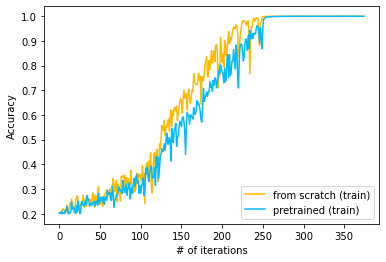

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

orange = "#fcba03"
light_blue = "#03bafc"

plt.plot(accs_scratch_random_train, linestyle="-", color=orange)
plt.plot(accs_upstream_random_train, linestyle="-", color=light_blue)
plt.xlabel('# of iterations')
plt.ylabel('Accuracy')
plt.legend(["from scratch (train)", "pretrained (train)"], loc ="lower right")
plt.show()

In [27]:
from torch import linalg as LA

train_upstream_loader, train_downstream_loader, test_loader = get_cifar10_sets(
    num_examples_upstream = 20000,
    num_examples_downstream = 20000,
    num_classes_upstream = 50,
    num_classes_downstream = 5,
    is_downstream_random = False,
    batch_size = 256
  )

model = get_vgg_model(50, 1)
norm_dict = {}
for name, param in model.named_parameters():
  norm_dict[name] = LA.norm(param)

epochs = 80
learnable_parameters = get_learnable_parameters(model)
criterion, optimizer, scheduler = get_training_components(learnable_parameters, 0.0009, (int)(epochs/3))

device = get_device()
model = model.to(device)
model.train()
loss_history = train(model, criterion, optimizer, epochs, train_upstream_loader, device, scheduler=scheduler)

# scale norms back to initial values after upstream training
for name, param in model.named_parameters():
  scale = norm_dict[name]
  param.data.copy_(param*(scale.item()/LA.norm(param)))

torch.save(model.state_dict(), "./pretrained_model_dict_upstream_3_4.pt")
torch.save(model, "./pretrained_model_upstream_3_4.pt")


Cuda (GPU support) is available and enabled!
Epoch 1 / 80: avg. loss of last 5 iterations 3.9110665798187254
Epoch: 1 LR: [0.0009]
Epoch 2 / 80: avg. loss of last 5 iterations 3.911507797241211
Epoch: 2 LR: [0.0009]
Epoch 3 / 80: avg. loss of last 5 iterations 3.908005619049072
Epoch: 3 LR: [0.0009]
Epoch 4 / 80: avg. loss of last 5 iterations 3.911918544769287
Epoch: 4 LR: [0.0009]
Epoch 5 / 80: avg. loss of last 5 iterations 3.906312274932861
Epoch: 5 LR: [0.0009]
Epoch 6 / 80: avg. loss of last 5 iterations 3.9068278312683105
Epoch: 6 LR: [0.0009]
Epoch 7 / 80: avg. loss of last 5 iterations 3.9093602180480955
Epoch: 7 LR: [0.0009]
Epoch 8 / 80: avg. loss of last 5 iterations 3.908145523071289
Epoch: 8 LR: [0.0009]
Epoch 9 / 80: avg. loss of last 5 iterations 3.9057024002075194
Epoch: 9 LR: [0.0009]
Epoch 10 / 80: avg. loss of last 5 iterations 3.903241443634033
Epoch: 10 LR: [0.0009]
Epoch 11 / 80: avg. loss of last 5 iterations 3.904736280441284
Epoch: 11 LR: [0.0009]
Epoch 12 / 8

In [28]:
# From scratch with real labels
loss_scratch_real, accs_scratch_real_train, accs_scratch_real_test = setup_and_train_downstream(
    epochs=40, lr=0.001, step_size=(int)(40/3), num_examples_upstream=20000, 
    num_examples_downstream=20000, num_classes_upstream = 5, num_classes_downstream = 10,
    is_downstream_random = False, batch_size = 256, num_outputs=10
)


Cuda (GPU support) is available and enabled!
Epoch 1 / 40: avg. loss of last 5 iterations 1.8802794933319091
Epoch 1 / 40: Last train acc:0.3318
Epoch 1 / 40: Last test acc:0.3353
Epoch: 1 LR: [0.001]
Epoch 2 / 40: avg. loss of last 5 iterations 1.6126515865325928
Epoch 2 / 40: Last train acc:0.3961
Epoch 2 / 40: Last test acc:0.3924
Epoch: 2 LR: [0.001]
Epoch 3 / 40: avg. loss of last 5 iterations 1.581407904624939
Epoch 3 / 40: Last train acc:0.4443
Epoch 3 / 40: Last test acc:0.4307
Epoch: 3 LR: [0.001]
Epoch 4 / 40: avg. loss of last 5 iterations 1.4076972484588623
Epoch 4 / 40: Last train acc:0.4559
Epoch 4 / 40: Last test acc:0.4438
Epoch: 4 LR: [0.001]
Epoch 5 / 40: avg. loss of last 5 iterations 1.448612427711487
Epoch 5 / 40: Last train acc:0.52115
Epoch 5 / 40: Last test acc:0.4942
Epoch: 5 LR: [0.001]
Epoch 6 / 40: avg. loss of last 5 iterations 1.3640332221984863
Epoch 6 / 40: Last train acc:0.54945
Epoch 6 / 40: Last test acc:0.5291
Epoch: 6 LR: [0.001]
Epoch 7 / 40: avg. 

In [31]:
# Using upstream training's weights with real labels
loss_upstream_real, accs_upstream_real_train, accs_upstream_real_test = setup_and_train_downstream(
    epochs=40, lr=0.001, step_size=(int)(40/3), num_examples_upstream=20000, 
    num_examples_downstream=20000, num_classes_upstream = 5, num_classes_downstream = 50,
    is_downstream_random = False, batch_size = 256, num_outputs=10,
    upstream_model_path = "pretrained_model_dict_upstream_3_4.pt"
)


Cuda (GPU support) is available and enabled!
Epoch 1 / 40: avg. loss of last 5 iterations 2.301101303100586
Epoch 1 / 40: Last train acc:0.1166
Epoch 1 / 40: Last test acc:0.1164
Epoch: 1 LR: [0.001]
Epoch 2 / 40: avg. loss of last 5 iterations 2.297889232635498
Epoch 2 / 40: Last train acc:0.1267
Epoch 2 / 40: Last test acc:0.126
Epoch: 2 LR: [0.001]
Epoch 3 / 40: avg. loss of last 5 iterations 2.2944099426269533
Epoch 3 / 40: Last train acc:0.15555
Epoch 3 / 40: Last test acc:0.1567
Epoch: 3 LR: [0.001]
Epoch 4 / 40: avg. loss of last 5 iterations 2.2819467067718504
Epoch 4 / 40: Last train acc:0.17225
Epoch 4 / 40: Last test acc:0.1747
Epoch: 4 LR: [0.001]
Epoch 5 / 40: avg. loss of last 5 iterations 2.258587121963501
Epoch 5 / 40: Last train acc:0.17395
Epoch 5 / 40: Last test acc:0.1722
Epoch: 5 LR: [0.001]
Epoch 6 / 40: avg. loss of last 5 iterations 2.2004987716674806
Epoch 6 / 40: Last train acc:0.18035
Epoch 6 / 40: Last test acc:0.181
Epoch: 6 LR: [0.001]
Epoch 7 / 40: avg. l

In [32]:
# From scratch with random labels
loss_upstream_real, accs_scratch_random_train = setup_and_train_downstream(
    epochs=75, lr=0.001, step_size=(int)(75/3), num_examples_upstream=20000, 
    num_examples_downstream=20000, num_classes_upstream = 5, num_classes_downstream = 50,
    is_downstream_random = True, batch_size = 256, num_outputs=50
)

Cuda (GPU support) is available and enabled!
Epoch 1 / 75: avg. loss of last 5 iterations 3.913318634033203
Epoch 1 / 75: Last train acc:0.02485
Epoch: 1 LR: [0.001]
Epoch 2 / 75: avg. loss of last 5 iterations 3.9126505851745605
Epoch 2 / 75: Last train acc:0.0256
Epoch: 2 LR: [0.001]
Epoch 3 / 75: avg. loss of last 5 iterations 3.910838794708252
Epoch 3 / 75: Last train acc:0.0283
Epoch: 3 LR: [0.001]
Epoch 4 / 75: avg. loss of last 5 iterations 3.9118015289306642
Epoch 4 / 75: Last train acc:0.0272
Epoch: 4 LR: [0.001]
Epoch 5 / 75: avg. loss of last 5 iterations 3.907556915283203
Epoch 5 / 75: Last train acc:0.0271
Epoch: 5 LR: [0.001]
Epoch 6 / 75: avg. loss of last 5 iterations 3.9097102642059327
Epoch 6 / 75: Last train acc:0.0318
Epoch: 6 LR: [0.001]
Epoch 7 / 75: avg. loss of last 5 iterations 3.9056958198547362
Epoch 7 / 75: Last train acc:0.0279
Epoch: 7 LR: [0.001]
Epoch 8 / 75: avg. loss of last 5 iterations 3.906880807876587
Epoch 8 / 75: Last train acc:0.03465
Epoch: 8 L

In [33]:
# Using upstream training's weights with random labels
loss_upstream_real, accs_upstream_random_train = setup_and_train_downstream(
    epochs=75, lr=0.001, step_size=(int)(75/3), num_examples_upstream=20000,
    num_examples_downstream=20000, num_classes_upstream = 5, num_classes_downstream = 50,
    is_downstream_random = True, batch_size = 256, num_outputs=50,
    upstream_model_path = "pretrained_model_dict_upstream_3_4.pt"
)

Cuda (GPU support) is available and enabled!
Epoch 1 / 75: avg. loss of last 5 iterations 3.9224101543426513
Epoch 1 / 75: Last train acc:0.0265
Epoch: 1 LR: [0.001]
Epoch 2 / 75: avg. loss of last 5 iterations 3.905296802520752
Epoch 2 / 75: Last train acc:0.03115
Epoch: 2 LR: [0.001]
Epoch 3 / 75: avg. loss of last 5 iterations 3.904061508178711
Epoch 3 / 75: Last train acc:0.0354
Epoch: 3 LR: [0.001]
Epoch 4 / 75: avg. loss of last 5 iterations 3.896678924560547
Epoch 4 / 75: Last train acc:0.03775
Epoch: 4 LR: [0.001]
Epoch 5 / 75: avg. loss of last 5 iterations 3.892476224899292
Epoch 5 / 75: Last train acc:0.03975
Epoch: 5 LR: [0.001]
Epoch 6 / 75: avg. loss of last 5 iterations 3.882950687408447
Epoch 6 / 75: Last train acc:0.0405
Epoch: 6 LR: [0.001]
Epoch 7 / 75: avg. loss of last 5 iterations 3.8768688678741454
Epoch 7 / 75: Last train acc:0.04325
Epoch: 7 LR: [0.001]
Epoch 8 / 75: avg. loss of last 5 iterations 3.8691803455352782
Epoch 8 / 75: Last train acc:0.04715
Epoch: 8

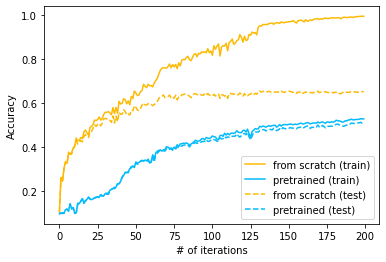

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

orange = "#fcba03"
light_blue = "#03bafc"

plt.plot(accs_scratch_real_train, linestyle="-", color=orange)
plt.plot(accs_upstream_real_train, linestyle="-", color=light_blue)
plt.plot(accs_scratch_real_test, linestyle="--", color=orange)
plt.plot(accs_upstream_real_test, linestyle="--", color=light_blue)
plt.legend(["from scratch (train)", "pretrained (train)", "from scratch (test)", "pretrained (test)"], loc ="best")
plt.xlabel('# of iterations')
plt.ylabel('Accuracy')
plt.show()

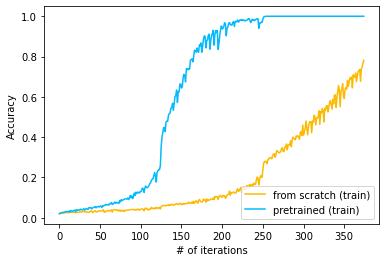

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

orange = "#fcba03"
light_blue = "#03bafc"

plt.plot(accs_scratch_random_train, linestyle="-", color=orange)
plt.plot(accs_upstream_random_train, linestyle="-", color=light_blue)
plt.xlabel('# of iterations')
plt.ylabel('Accuracy')
plt.legend(["from scratch (train)", "pretrained (train)"], loc ="lower right")
plt.show()